In [15]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import umap
from collections import Counter
import re
import datetime
from tqdm import tqdm

from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()
#unpatch_sklearn()

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from tqdm import tqdm

from platform import python_version

python_version(), np.__version__, pd.__version__, sklearn.__version__, matplotlib.__version__, sns.__version__, umap.__version__

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


('3.8.12', '1.20.3', '1.3.3', '1.0.1', '3.4.2', '0.11.2', '0.5.2')

# Experimento de classificadores Ensemble

## Neste experimento vamos pegar uma fração dos dados de fraud-detection do Kaggle (3000 amostras, ou ~5% da base) para realizar os experimentos ensemble com classificadores fracos (Decision Tree, LogisticRegression, etc.) e realizar um benchmark contra um outro Ensemble mais robusto, como o RandomForest.

## O valor pequeno de amostras foi escolhido para cumprir com o requerimento do exercício, de no mínimo 1000 amostras, e também para diminuir o tempo total do experimento pela pesquisa de GridSearch ou RandomSearch.

<AxesSubplot:>

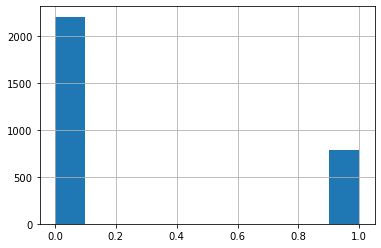

In [139]:
# Dataset capturado do desafio https://www.kaggle.com/volodymyrgavrysh/fraud-detection-bank-dataset-20k-records-binary
df = pd.read_csv('../data/fraud_detection_bank_dataset.csv',index_col=0)

#filtrando para 3000 samples, atendendo ao requisito do enunciado do problema
X = df.drop('targets',axis=1).sample(3000,random_state=42) 
y = df.loc[X.index].targets

y.hist()

In [140]:
display(X.describe().T)

count        mean         std  min   25%   50%     75%      max
col_0    3000.0    3.921333   43.992108  0.0   0.0   0.0    2.00   2301.0
col_1    3000.0  299.905000  940.911091  0.0  35.0  90.5  264.25  37808.0
col_2    3000.0    0.259000    1.320290  0.0   0.0   0.0    0.00     37.0
col_3    3000.0    2.039333    6.201016  0.0   0.0   1.0    2.00    178.0
col_4    3000.0    0.095333    0.858579  0.0   0.0   0.0    0.00     26.0
...         ...         ...         ...  ...   ...   ...     ...      ...
col_107  3000.0    0.189667    0.392103  0.0   0.0   0.0    0.00      1.0
col_108  3000.0    0.000000    0.000000  0.0   0.0   0.0    0.00      0.0
col_109  3000.0    0.046667    0.210959  0.0   0.0   0.0    0.00      1.0
col_110  3000.0    0.030333    0.429893  0.0   0.0   0.0    0.00     17.0
col_111  3000.0   42.005000   60.253635  0.0   5.0  17.0   60.00    728.0

[112 rows x 8 columns]

## Escolha dos classificadores para ensemble

Vamos escolher os classificadores da lista de classificadores simples, e utilizarmos o RandomForestClassifier como benchmark

In [144]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,StackingClassifier

In [145]:
%%time
models = [DecisionTreeClassifier(),LogisticRegression(),KNeighborsClassifier(),
          GaussianNB(),SVC(),RandomForestClassifier()]
results = []
for model in models:
    pipe = Pipeline([
        ('scaler',StandardScaler()),
        ('cf',model)
    ])
    r = cross_validate(pipe,X,y,cv=RepeatedStratifiedKFold(),n_jobs=-1,return_estimator=True)
    results.append(pd.DataFrame(r))

Wall time: 8.96 s


In [146]:
for res in results:
    print(res.estimator[0],res.test_score.mean())

Pipeline(steps=[('scaler', StandardScaler()), ('cf', DecisionTreeClassifier())]) 0.8836666666666667
Pipeline(steps=[('scaler', StandardScaler()), ('cf', LogisticRegression())]) 0.8741333333333334
Pipeline(steps=[('scaler', StandardScaler()), ('cf', KNeighborsClassifier())]) 0.8695666666666669
Pipeline(steps=[('scaler', StandardScaler()), ('cf', GaussianNB())]) 0.7676
Pipeline(steps=[('scaler', StandardScaler()), ('cf', SVC())]) 0.858
Pipeline(steps=[('scaler', StandardScaler()), ('cf', RandomForestClassifier())]) 0.9155333333333334


### Descartaremos o GaussianNB e SVC pelos menores desempenhos individuais, e levaremos para os ensembles somente os demais para comparativo com o RandomForest

In [147]:
%%time
models = [RandomForestClassifier(),
          VotingClassifier([
              ('dt',DecisionTreeClassifier()),
              ('lr',LogisticRegression()),
              ('knn',KNeighborsClassifier())
          ]),
          StackingClassifier([
              ('dt',DecisionTreeClassifier()),
              ('lr',LogisticRegression()),
              ('knn',KNeighborsClassifier())
          ])
         ]
results = []
for model in models:
    pipe = Pipeline([
        ('scaler',StandardScaler()),
        ('cf',model)
    ])
    r = cross_validate(pipe,X,y,cv=RepeatedStratifiedKFold(),n_jobs=-1,return_estimator=True)
    results.append(pd.DataFrame(r))

Wall time: 9.77 s


In [148]:
for res in results:
    print(res.estimator[0],res.test_score.mean())

Pipeline(steps=[('scaler', StandardScaler()), ('cf', RandomForestClassifier())]) 0.9152000000000001
Pipeline(steps=[('scaler', StandardScaler()),
                ('cf',
                 VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                                              ('lr', LogisticRegression()),
                                              ('knn',
                                               KNeighborsClassifier())]))]) 0.9020666666666667
Pipeline(steps=[('scaler', StandardScaler()),
                ('cf',
                 StackingClassifier(estimators=[('dt',
                                                 DecisionTreeClassifier()),
                                                ('lr', LogisticRegression()),
                                                ('knn',
                                                 KNeighborsClassifier())]))]) 0.9078666666666667


### Na primeira rodada de Ensemble já conseguimos melhorar o resultados dos classificadores fracos, tando com Voting quanto com Stacking.

In [189]:
def get_n_iter(gridParam):
    n_iter = 1
    for key in gridParam:
        n_iter *= (len(gridParam[key]))

    if n_iter*0.1 > 120: n_iter = (0.1*n_iter)//1
    
    print('Define n_iter: ',n_iter)
    return n_iter

models = [RandomForestClassifier(random_state=42),
          GradientBoostingClassifier(random_state=42),
          VotingClassifier([
              ('dt',DecisionTreeClassifier(random_state=42)),
              ('lr',LogisticRegression(random_state=42)),
              ('knn',KNeighborsClassifier())
          ]),
          StackingClassifier([
              ('dt',DecisionTreeClassifier(random_state=42)),
              ('lr',LogisticRegression(random_state=42)),
              ('knn',KNeighborsClassifier())
          ])
         ]

gridParam = {
    'cf__n_estimators':[100, 150],
    'cf__max_depth':[9,13,17],
    'cf__min_samples_leaf': [1, 3, 5],
    'cf__criterion': ['gini','entropy'],
    'cf__class_weight':["balanced", "balanced_subsample",None]
}

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('cf', RandomForestClassifier(random_state=42))
])


model = RandomizedSearchCV(pipe,refit=True,n_jobs=-1,random_state=42,verbose=True,cv=RepeatedStratifiedKFold(n_repeats=3),
                          n_iter=get_n_iter(gridParam),param_distributions=gridParam)
pipe.get_params().keys()

Define n_iter:  108


dict_keys(['memory', 'steps', 'verbose', 'scaler', 'cf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'cf__bootstrap', 'cf__ccp_alpha', 'cf__class_weight', 'cf__criterion', 'cf__maxBins', 'cf__max_depth', 'cf__max_features', 'cf__max_leaf_nodes', 'cf__max_samples', 'cf__minBinSize', 'cf__min_impurity_decrease', 'cf__min_samples_leaf', 'cf__min_samples_split', 'cf__min_weight_fraction_leaf', 'cf__n_estimators', 'cf__n_jobs', 'cf__oob_score', 'cf__random_state', 'cf__verbose', 'cf__warm_start'])

In [190]:
%%time
model.fit(X,y)

print(model.best_score_)
model.best_params_

0.9163333333333331
Wall time: 1min 30s


{'cf__n_estimators': 150,
 'cf__min_samples_leaf': 1,
 'cf__max_depth': 17,
 'cf__criterion': 'entropy',
 'cf__class_weight': None}

### Mesmo fazendo RandomSearch no RandonForest conseguimos melhorar um pouco o desempenho do classificador.

In [191]:
gridParam = {
    'cf__max_depth':[7,9,13],
    'cf__max_features': [0.8, 1.0],
    'cf__min_samples_leaf': [1,3,5],
    'cf__criterion': ['gini','entropy'],
    'cf__class_weight':["balanced",None],
    #'cf__lr__C': [0.5,1,2],
    #'cf__lr__class_weight': ["balanced",None],
    #'cf__knn__n_neighbors': [3,5,7]
}

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('cf', DecisionTreeClassifier(random_state=42)),
])


model = RandomizedSearchCV(pipe,refit=True,n_jobs=-1,random_state=42,verbose=True,cv=RepeatedStratifiedKFold(n_repeats=3),
                          n_iter=get_n_iter(gridParam),param_distributions=gridParam)
pipe.get_params().keys()

Define n_iter:  72


dict_keys(['memory', 'steps', 'verbose', 'scaler', 'cf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'cf__ccp_alpha', 'cf__class_weight', 'cf__criterion', 'cf__max_depth', 'cf__max_features', 'cf__max_leaf_nodes', 'cf__min_impurity_decrease', 'cf__min_samples_leaf', 'cf__min_samples_split', 'cf__min_weight_fraction_leaf', 'cf__random_state', 'cf__splitter'])

In [192]:
%%time
model.fit(X,y)

print('BEST SCORE:', model.best_score_)
print('BEST PARAMS:\n', model.best_params_)

Fitting 15 folds for each of 72 candidates, totalling 1080 fits
BEST SCORE: 0.8997777777777778
BEST PARAMS:
 {'cf__min_samples_leaf': 5, 'cf__max_features': 1.0, 'cf__max_depth': 9, 'cf__criterion': 'entropy', 'cf__class_weight': None}
Wall time: 7.19 s


In [193]:
gridParam = {
    #'cf__max_depth':[7,9,13],
    #'cf__max_features': [0.8, 1.0],
    #'cf__min_samples_leaf': [1,3,5],
    #'cf__criterion': ['gini','entropy'],
    #'cf__class_weight':["balanced",None],
    'cf__C': [0.5,1,2],
    'cf__class_weight': ["balanced",None],
    #'cf__knn__n_neighbors': [3,5,7]
}

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('cf', LogisticRegression(random_state=42,max_iter=500)),
])


model = RandomizedSearchCV(pipe,refit=True,n_jobs=-1,random_state=42,verbose=True,cv=RepeatedStratifiedKFold(n_repeats=3),
                          n_iter=get_n_iter(gridParam),param_distributions=gridParam)
pipe.get_params().keys()

Define n_iter:  6


dict_keys(['memory', 'steps', 'verbose', 'scaler', 'cf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'cf__C', 'cf__class_weight', 'cf__dual', 'cf__fit_intercept', 'cf__intercept_scaling', 'cf__l1_ratio', 'cf__max_iter', 'cf__multi_class', 'cf__n_jobs', 'cf__penalty', 'cf__random_state', 'cf__solver', 'cf__tol', 'cf__verbose', 'cf__warm_start'])

In [194]:
%%time
model.fit(X,y)

print('BEST SCORE:', model.best_score_)
print('BEST PARAMS:\n', model.best_params_)

Fitting 15 folds for each of 6 candidates, totalling 90 fits
BEST SCORE: 0.8733333333333333
BEST PARAMS:
 {'cf__class_weight': None, 'cf__C': 1}
Wall time: 2.31 s


In [195]:
gridParam = {
    #'cf__max_depth':[7,9,13],
    #'cf__max_features': [0.8, 1.0],
    #'cf__min_samples_leaf': [1,3,5],
    #'cf__criterion': ['gini','entropy'],
    #'cf__class_weight':["balanced",None],
    #'cf__C': [0.5,1,2],
    #'cf__class_weight': ["balanced",None],
    'cf__n_neighbors': [3,5,7]
}

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('cf', KNeighborsClassifier()),
])


model = RandomizedSearchCV(pipe,refit=True,n_jobs=-1,random_state=42,verbose=True,cv=RepeatedStratifiedKFold(n_repeats=3),
                          n_iter=get_n_iter(gridParam),param_distributions=gridParam)
pipe.get_params().keys()

Define n_iter:  3


dict_keys(['memory', 'steps', 'verbose', 'scaler', 'cf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'cf__algorithm', 'cf__leaf_size', 'cf__metric', 'cf__metric_params', 'cf__n_jobs', 'cf__n_neighbors', 'cf__p', 'cf__weights'])

In [196]:
%%time
model.fit(X,y)

print('BEST SCORE:', model.best_score_)
print('BEST PARAMS:\n', model.best_params_)

Fitting 15 folds for each of 3 candidates, totalling 45 fits
BEST SCORE: 0.8712222222222222
BEST PARAMS:
 {'cf__n_neighbors': 3}
Wall time: 482 ms


### Fazendo a otimização dos parametros individuais dos classificadores fracos conseguimos melhorar muito pouco o resultado de cada um.

## Agora, faremos a otimização integrada dos pipelines ensemble

In [197]:
gridParam = {
    'cf__dt__max_depth':[7,9,13],
    'cf__dt__max_features': [0.8, 1.0],
    'cf__dt__min_samples_leaf': [1,3,5],
    'cf__dt__criterion': ['gini','entropy'],
    'cf__dt__class_weight':["balanced",None],
    'cf__lr__C': [0.5,1,2],
    'cf__lr__class_weight': ["balanced",None],
    'cf__knn__n_neighbors': [3,5,7]
}

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('cf', VotingClassifier([
              ('dt',DecisionTreeClassifier(random_state=42)),
              ('lr',LogisticRegression(random_state=42,max_iter=500)),
              ('knn',KNeighborsClassifier())
          ]))
])


model = RandomizedSearchCV(pipe,refit=True,n_jobs=-1,random_state=42,verbose=True,cv=RepeatedStratifiedKFold(n_repeats=3),
                          n_iter=get_n_iter(gridParam),param_distributions=gridParam)
pipe.get_params().keys()

Define n_iter:  129.0


dict_keys(['memory', 'steps', 'verbose', 'scaler', 'cf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'cf__estimators', 'cf__flatten_transform', 'cf__n_jobs', 'cf__verbose', 'cf__voting', 'cf__weights', 'cf__dt', 'cf__lr', 'cf__knn', 'cf__dt__ccp_alpha', 'cf__dt__class_weight', 'cf__dt__criterion', 'cf__dt__max_depth', 'cf__dt__max_features', 'cf__dt__max_leaf_nodes', 'cf__dt__min_impurity_decrease', 'cf__dt__min_samples_leaf', 'cf__dt__min_samples_split', 'cf__dt__min_weight_fraction_leaf', 'cf__dt__random_state', 'cf__dt__splitter', 'cf__lr__C', 'cf__lr__class_weight', 'cf__lr__dual', 'cf__lr__fit_intercept', 'cf__lr__intercept_scaling', 'cf__lr__l1_ratio', 'cf__lr__max_iter', 'cf__lr__multi_class', 'cf__lr__n_jobs', 'cf__lr__penalty', 'cf__lr__random_state', 'cf__lr__solver', 'cf__lr__tol', 'cf__lr__verbose', 'cf__lr__warm_start', 'cf__knn__algorithm', 'cf__knn__leaf_size', 'cf__knn__metric', 'cf__knn__metric_params', 'cf__knn__n_jobs', 'cf__knn__n_neighbors', 'cf__knn__

In [198]:
%%time
model.fit(X,y)

print('BEST SCORE:', model.best_score_)
print('BEST PARAMS:\n', model.best_params_)

Fitting 15 folds for each of 129 candidates, totalling 1935 fits
BEST SCORE: 0.9079999999999999
BEST PARAMS:
 {'cf__lr__class_weight': None, 'cf__lr__C': 2, 'cf__knn__n_neighbors': 5, 'cf__dt__min_samples_leaf': 3, 'cf__dt__max_features': 1.0, 'cf__dt__max_depth': 7, 'cf__dt__criterion': 'gini', 'cf__dt__class_weight': None}
Wall time: 50.4 s


### Fazendo RandomizedSearch no Voting, já conseguimos melhorar o resultado consideravelmente.

In [199]:
gridParam = {
    'cf__passthrough': [False,True],
    'cf__dt__max_depth':[7,9,13],
    'cf__dt__max_features': [0.8, 1.0],
    'cf__dt__min_samples_leaf': [1,3,5],
    'cf__dt__criterion': ['gini','entropy'],
    'cf__dt__class_weight':["balanced",None],
    'cf__lr__C': [0.5,1],
    'cf__lr__class_weight': ["balanced",None],
    'cf__knn__n_neighbors': [3,5,7]
}

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('cf', StackingClassifier([
              ('dt',DecisionTreeClassifier(random_state=42)),
              ('lr',LogisticRegression(random_state=42,max_iter=500)),
              ('knn',KNeighborsClassifier())
          ]))
])


model = RandomizedSearchCV(pipe,refit=True,n_jobs=-1,random_state=42,verbose=True,cv=RepeatedStratifiedKFold(n_repeats=3),
                          n_iter=get_n_iter(gridParam),param_distributions=gridParam)
pipe.get_params().keys()

Define n_iter:  172.0


dict_keys(['memory', 'steps', 'verbose', 'scaler', 'cf', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'cf__cv', 'cf__estimators', 'cf__final_estimator', 'cf__n_jobs', 'cf__passthrough', 'cf__stack_method', 'cf__verbose', 'cf__dt', 'cf__lr', 'cf__knn', 'cf__dt__ccp_alpha', 'cf__dt__class_weight', 'cf__dt__criterion', 'cf__dt__max_depth', 'cf__dt__max_features', 'cf__dt__max_leaf_nodes', 'cf__dt__min_impurity_decrease', 'cf__dt__min_samples_leaf', 'cf__dt__min_samples_split', 'cf__dt__min_weight_fraction_leaf', 'cf__dt__random_state', 'cf__dt__splitter', 'cf__lr__C', 'cf__lr__class_weight', 'cf__lr__dual', 'cf__lr__fit_intercept', 'cf__lr__intercept_scaling', 'cf__lr__l1_ratio', 'cf__lr__max_iter', 'cf__lr__multi_class', 'cf__lr__n_jobs', 'cf__lr__penalty', 'cf__lr__random_state', 'cf__lr__solver', 'cf__lr__tol', 'cf__lr__verbose', 'cf__lr__warm_start', 'cf__knn__algorithm', 'cf__knn__leaf_size', 'cf__knn__metric', 'cf__knn__metric_params', 'cf__knn__n_jobs', 'cf__knn__n_neig

In [200]:
%%time
model.fit(X,y)

print('BEST SCORE:', model.best_score_)
print('BEST PARAMS:\n', model.best_params_)

Fitting 15 folds for each of 172 candidates, totalling 2580 fits
BEST SCORE: 0.9171111111111111
BEST PARAMS:
 {'cf__passthrough': False, 'cf__lr__class_weight': 'balanced', 'cf__lr__C': 1, 'cf__knn__n_neighbors': 5, 'cf__dt__min_samples_leaf': 5, 'cf__dt__max_features': 0.8, 'cf__dt__max_depth': 7, 'cf__dt__criterion': 'entropy', 'cf__dt__class_weight': None}
Wall time: 4min 54s


### Com Ensemble Stacking, após otimização dos hiper-parametros, conseguimos chegar em um resultado de 0.917 no cross validation contra o RandomForest em 0.916, utilizando somente com 3 classificadores fracos ensembled.

# Validando os resultados contra os dados não vistos no fit (85% da base deste desafio do Kaggle para testes finais)

In [201]:
X_test = df.loc[~df.index.isin(X.index)].drop('targets',axis=1)
y_test = df.loc[X_test.index].targets
X_test.shape,y_test.shape,X_test.shape[0]/df.shape[0]

((17468, 112), (17468,), 0.8534297439906195)

In [202]:
y_pred = model.predict(X_test)

In [203]:
accuracy_score(y_test,y_pred),balanced_accuracy_score(y_test,y_pred)

(0.9154453858484085, 0.8827191196818446)

In [208]:
#{'cf__n_estimators': 150, 'cf__min_samples_leaf': 1, 'cf__max_depth': 17, 'cf__criterion': 'entropy', 'cf__class_weight': None}
y_pred_bench = RandomForestClassifier(random_state=42,min_samples_leaf=1,n_estimators=150,
                                      max_depth=17,criterion='entropy',
                                      class_weight=None).fit(X.to_numpy(),y).predict(X_test.to_numpy())

accuracy_score(y_test,y_pred_bench),balanced_accuracy_score(y_test,y_pred_bench)

(0.9181932676894894, 0.8691565479065702)

# Conclusões:

### Neste experimento e exercício conseguimos melhorar significativamente o resultado dos classificadores fracos com uma técnica de Ensemble, obtendo bons resultados mesmo tendo somente treinado com uma pequena fração dos dados em um dataset desbalanceado (~5% da base com desbalanceamento de 3/1 nos rótulos).

### Interessantemente o RandomForest apresentou um melhor resultado nos testes finais no accuracy score, mas pior resultado no balanced accuracy score comparado ao nosso Ensemble. Provavelmente este fato se deu pela maior generalização do RandomForest em poucos dados de treino.